<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Bias & Variance (Machine Learning)

In machine learning, understanding the concepts of **model bias** and **model variance** is essential for building models that generalize well to new, unseen data. These two sources of error describe how a model learns from data and how its predictions might deviate from the true underlying patterns. Bias refers to the error introduced by making assumptions in the learning algorithm, while variance refers to the error caused by sensitivity to small fluctuations in the training data. Together with irreducible error (caused by noise in the data), bias and variance form the foundation of model performance.

**Model bias** occurs when a model is too simplistic to capture the complexity of the data. For instance, using a linear model to fit a highly non-linear relationship will result in consistently inaccurate predictions, regardless of the training data. This is known as underfitting. On the other hand, **model variance** reflects how much the model's predictions change if it is trained on different subsets of the data. A high-variance model may perform well on the training data but poorly on the test data because it overfits the noise and specific patterns of the training set.

A deep understanding of bias and variance is crucial during model development and evaluation. It helps practitioners diagnose whether a model is underfitting or overfitting and guides decisions such as choosing a more complex algorithm, adjusting hyperparameters, collecting more data, or applying regularization techniques. Without this understanding, efforts to improve model performance may be misguided—for example, trying to reduce error by increasing model complexity when the model is already suffering from high variance could make performance worse.

Moreover, bias and variance also influence how we validate models and interpret evaluation metrics. Techniques like cross-validation are designed to give reliable estimates of how a model will perform on unseen data, by accounting for variability due to training data selection. Evaluating models without considering bias and variance can lead to overconfidence in a model's performance, particularly if test data is not representative or if the model is overly complex for the available data.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.biasvariance import *
from src.utils.plotting.biasvariance import *
from src.utils.data.files import *

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
example_data, _ = download_dataset("tabular/regression/bias-variance-example-data.csv")

File 'data/datasets/tabular/regression/bias-variance-example-data.csv' already exists (use 'overwrite=True' to overwrite it).


---

## Quick Recap: Supervised Machine Learning

Writing an algorithm to solve a problem traditionally means explicitly programming a set of well-defined rules or instructions that the computer follows to reach a solution. This approach works well when the problem is fully understood and the steps to solve it are clear, such as sorting a list or calculating the shortest path in a graph. However, for many problems, the rules for solving them are too complex or simply unknown. Classic examples examples of such problems are:

* **Data Mining** (e.g., fraud detection, medical diagnosis & risk prediction, credit scoring & risk assessment)

* **Natural Language Processing** (e.g., text classification, machine translation, text summarization, question answering)

* **Computer Vision** (e.g., image classification, object detection, semantic segmentation, image generation)

These and similar problems are commonly addressed using **machine learning**. Instead of specifying exact instructions, the programmer provides a **model** that learns from data. The model identifies patterns and relationships in the data to make predictions or decisions. 

As one of the main types of machine learning, **supervised learning** captures the idea of learning from examples or samples. In supervised learning, the learning algorithm is given input-output pairs &mdash; examples or samples &mdash; from which it tries to learn a function mapping inputs to outputs. Let's denote a sample as $(x, y)$, where $x$ is the input described as a single value or a feature vector, and $y$ is the output (either numerical value or a label). We also use $X$ and $Y$ as the sets of all possible inputs and outputs, respectively. The dataset $D$ containing all examples is defined as.

$$\large
D = \left\{(x_1, y_1), (x_2, y_2), \cdots , (x_n, y_n) \right\}
$$

where $x_i\in X$ and $y_i\in Y$. It is assumed that the $D$ consists of a sample of independent and identically distributed (i.i.d) pairs. **Independent** means that each sample is not influenced by or correlated with any other sample. In other words, the features and labels of one sample do not tell us anything about another sample. **Identically distributed** means that all samples come from the same underlying probability distribution &mdash; that is, the process that generated the data is consistent across all samples.

For supervised machine learning to work in the first place, we also have to assume that there exists some mapping or function $f: X\rightarrow Y$ mapping the inputs to the corresponding outputs that describes the **true relationship** between $X$ and $Y$. Unfortunately, this true relationship described by $f(x)$ is unknown. We generally also cannot directly observe $f(x)$ from our dataset $D$ for two main reasons

* **Insufficient data:** The more complex the function we want to estimate, the more data we need to find a good estimate. For example, estimating a higher-order polynomial generally requires much more data samples the estimating a line (i.e., a polynomial of degree 1). This problem increases exponentially with the number of features of each input $x$.

* **Random noise:** In the context of regression tasks &mdash; that is, all $y_i$ are real-valued labels &mdash; we assume that the data is generated by function $f(x)$ such as $y = f (x) + \epsilon$, where the noise $\epsilon$ has zero mean (i.e., $E(e_i) = 0$) and variance $\sigma^{2}$. That is, $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i$ is a noise sample.

The goal of supervised machine learning is now to approximate or estimate $f(x)$ as best as possible &mdash; we commonly call such an estimate a **hypothesis** $h(x)$. A naive way to accomplish this would be to simply memorize all samples in $D$. This would ensure that for all samples in our dataset, we always map the input to the correct output, i.e., $h(x_i)=y_i$ for all $(x_i, y_i)\in D$. However, we want to use $h$ to correctly predict the output for unknown samples not present in $D$. For this, simply memorizing $D$ does not work. In other words, we need to find a "proper" hypothesis $h(x)$. This means, in practice, we want to find a good hypothesis $h(x)$ such that $h(x_i) \thickapprox y_i$ for all $(x_i, y_i)\in D$.

---

## Bias vs. Variance: Intuition

Before we look at the formal definitions for bias and variance, let's first get a good intuition and understanding about the both concepts and how they relate to training and evaluating models in supervised machine learning.

### Example Use Case

For our illustrations, we consider the most basic regression task where our inputs have only a single feature, and let's assume that our true relationship between the inputs and outputs is described by the function $f(x) = \sin{x}$, with constraint $x\in [0, 2\pi]$. Based on this, we created a simple dataset containing $200$ data samples such that $y_i = f(x_i) + \epsilon$, with $e_{i} \sim \mathcal{N}(0, 35)$. 

In the code cell below, first load the data into a Pandas DataFrame, convert the columns for inputs `X` and outputs `y` into a NumPy array, and split the data in 50% training data and 50% test data. We use the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method provided by the scikit-learn library for that last step.

In [3]:
# Load data in to Pandas DataFrame
df = pd.read_csv(example_data)
# Concert DataFrame columns into NumPy arrays
X, y = df["x"].to_numpy().reshape(-1, 1), df["y"].to_numpy()
# Split dataset 50:50 into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

We also provide an auxiliary method `plot_data()` to have a look at the data and its distribution; just run the code cell below. The plot shows the distribution of the 100 data samples from the training dataset, as well as the function $f(x) = \sin{x}$ describing the true relationship between inputs and outputs (black dashed line).

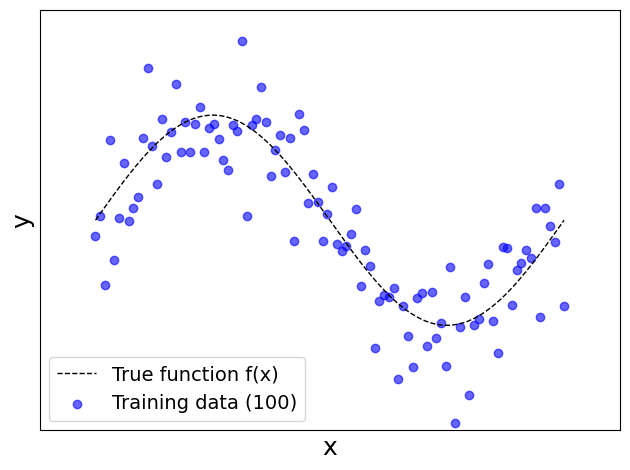

In [4]:
plot_data(X_train, y_train)

Of course, in practice, we would not know the true function $f(x)$ and instead want to find a hypothesis $h(x)$ to estimate $f(x)$ as best as possible &mdash; in simple terms, we cannot see the black dashed line in the previous plot. In the following, we assume that $f(x)$ can be fitted using a polynomial of the form

$$\large
\hat{y} = h(x) = w_0 + w_1 x + w_2 x^2 + \cdots + w_p x^p
$$

where $p$ is the degree of the polynomial, and $w_0, w_1, w_2, \dots, w_p$ are the coefficients or weights. Since the actual process of fitting a polynomial is not the focus of this notebook, we rely on existing implementations to perform Polynomial Linear Regression. Under the hood, we will be using the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) and the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class for this. The [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. Since we only have one feature, an input sample of the form $[x]$ will yield the degree-3 polynomial features are $[1, x, x^2, x^3]$.

### Effect of Polynomial Degree

Let's first explore how the choice of $p$ as the degree of the polynomial affects how well$h(x)$ estimates $f(x)$ &mdash; here we only assess the $h(x)$ qualitatively by plotting and inspecting the results. Just by looking at the data distribution, we can already expect that a polynomial of degree $p=0$ (horizontal line) or of degree $p=1$ (sloped line) will arguably not result in good estimates. Even a polynomial of degree $p=2$ (parabola) is unlikely to be a good fit.

To confirm this, we provide an auxiliary method `plot_results()` takes in the training data to train a Polynomial Linear Regression &mdash; the degree of the polynomial is also an input argument of the methods &mdash; and plots the fitted line described by $h(x)$ together with the data samples and the true function $f(x)$.

**Your turn:** Change the degree of the polynomial by changing the values of variable `poly_degree` (recommended values $0..9$) and see how it affects the result.

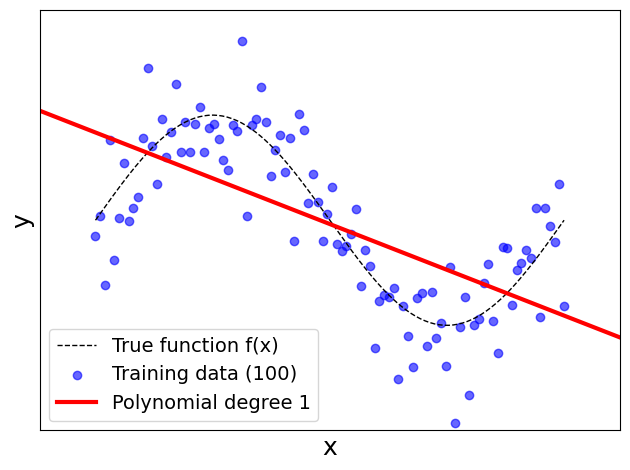

In [5]:
poly_degree = 1 # Recommended values: 0..9

plot_results(X_train, y_train, poly_degree=poly_degree)

For convenience, we also create an animation that cycles through all results for the degrees $0$ to $9$ for the polynomial. Before continuing, have a good look at the animation and think for yourself what those results tell you and if they match your expectations.

<img src="images/animations/biasvariance/biasvariance-effect-of-degree.gif" />

Having tried different values for $p$ yourself or having watched the animation above, you are likely have made the following key observation:

* **Small polynomial degrees underperform:** Unsurprisingly, for $p=0..2$, our hypothesis $h(x)$ does a poor job estimating the true function $f(x)$. The reason is that for small polynomial degrees, our regression model makes simplifying assumptions about the underlying relationship between the input features and the output. For example, for $p=1$ the model assumes that the true relationship is linear (constant for $p=0$, quadratic for $p=2$) which clearly is not true. It's like having a preconceived notion or a strong "opinion" about how things should work, even before looking closely at all the data, which is often not difficult or impossible in practice. These simplifying assumptions inherently introduce an error called the **bias** or **model bias** (since this term has different meanings depending on the context). We also often say that our model has **insufficient capacity** to properly fit the data. The bias is a **systematic error** since the model makes predictions that are consistently off in a particular and understandable way. It generally also cannot be reduced by simply adding more training data or repeated training. In simple terms, you can think of bias as the model being wrong in the same way every time.

* **Increases the polynomial degree (always?) helps:** Since we know the true relationship is based on the sine function and we limit the range of the inputs to $x\in [0, 2\pi]$, you might have already expected that $f(x)$ can be estimated using a cubic polynomial (i.e., $p=3$). And indeed, for $p=3$ or higher degrees, $h(x)$ arguably represents a good estimate for $f(x)$. In other words, our model now has sufficient capacity to fit the data. One might even think, based on those results, that we should always set $p$ as high as possible. However, we will see in a bit that this would be a naive conclusion.

* **Validity of model:** A first hint why simply increasing the polynomial degree $p$ might cause problems is given by the behaviors of $h(x)$ at the boundaries of the input range $[0, 2\pi]$ and beyond. Models such as (Polynomial) Linear Regression inherently allow for **extrapolation** &mdash; that is, the prediction of outputs for unseen inputs outside the range of the training data. The plots show that for different values of $p$ the trend of $h(x)$ beyond the range $[0, 2\pi]$ can vary significantly. Note that extrapolation is a concern for any machine learning task, and we generally try to ensure that our training is both sufficiently large and sufficiently representative (i.e., new unseen samples are arbitrarily unlikely to be outside the range of the training data).

The key takeaway message of these first results are that a **biased model** &mdash; again, a model that makes simplifying assumptions about the data &mdash; will perform poorly due to systematic errors. This lack of capacity or complexity of the model typically leads to the notion of **underfitting**. In short, a biased model is likely to underfit the data. Reducing the bias generally means to increase the model complexity. 

### Effect of Dataset Size

We just saw that a model needs to have enough capacity to fit the data well. In some sense, the complexity of the model has to match the complexity of the data distribution. For our example data, since we have roughly a cubic true relationship, we need at least a polynomial of degree $p=3$ to appropriately fit the data. The previous results might also give the impression that we can also just increase $p$ &mdash; maybe just to be on the safe side since we often cannot reliably assess the complexity of the data.

The reason for this impression, however, is that we are working with an almost idealistic scenario. Given that our inputs have only a single feature from a small range, the total number of 100 training samples is very high; illustrated by the dense data distribution in the plots above. In contrast, real-world data is often sparse. So let's recreate a sparse setting where we generate the same results but only using a subset of the training data. In the code cell below, you can again play with the value of $p$ but now also with the size of the training data. For example, with `n_points_subset = 20`, the Polynomial Linear Regression model will be trained using only $20$ random data samples from the $100$ data samples in the original training data.

**Your turn:** Try out different values for `poly_degree` and `n_points_subset` to see how they affect the results.

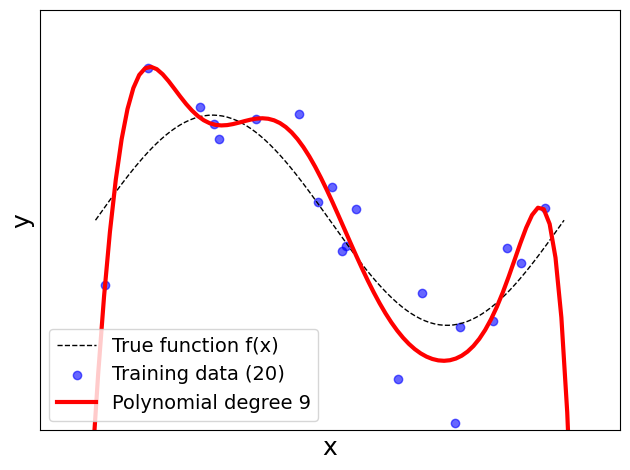

In [6]:
poly_degree = 9 # recommended 0..9
n_points_subset = 20 # recommended 10..30

# Pick a random subset of indices of size n_points_size
indices = np.random.choice(len(X_train), size=n_points_subset, replace=False)
# Create a subset of the training data using the random subset of indices
X_train_sub, y_train_sub = X_train[indices], y_train[indices]

plot_results(X_train_sub, y_train_sub, poly_degree=poly_degree)

Testing all recommended degrees $p=0..9$ with various sizes for the training dataset can be a bit tedious. We therefore provide another animation showing none plots in parallel; see below. Each individual plot shows the result for a specific value for $p$ ranging from $1$ to $9$ (we omitted $p=0$ to ease presentation). For each polynomial degree $p$, we start with the full training dataset of $100$ samples and iteratively reduce the dataset size by removing $10$ samples after every iteration. In each iteration, we fit a Polynomial Linear Regression model over the reduced dataset and update plot. This process continues until the training dataset contains only $10$ data samples in total.

Again, before you continue, take your time to inspect the plots and their changes over time for each value of $p$. What observations did you make?

<img src="images/animations/biasvariance/biasvariance-effect-of-dataset-size.gif" />

The plots clearly show that the fitted line described by the current hypotheses $h(x)$ is more stable or less varied for lower values of $p $. For larger values, we can see that the shape and trend of the fitted line can change significantly when decreasing the size of the training data. For example, with $p=9$, the model is much more capable to better fit individual data points &mdash; and recall that each data sample is associated with a sample noise $\epsilon_i$. Thus, if our small(er) training dataset contains many samples with a lot of noise, a high-order polynomial model has "too much" capacity and is able to fit the noise (instead just the true relationship).

In fact, if you observe the plots for $p=9$ or check for yourself using `poly_degree = 9` and `n_points_subset = 10` using the previous code cell, you can see that the regression line perfectly fits all data samples. In other words, the training error would be $0$. However, the corresponding fitted lines show extreme trends that do not reflect the true relationship between the inputs and the outputs at all. Again, the problem is that each data sample contains noise and the model has sufficient capacity to fit those noisy samples. Of course, it should be obvious that this model is likely to perform very poorly. Even for unseen data samples &mdash; due to the extreme trends &mdash; the model will often make very wrong predictions.

If a model is fitting the noise in the training data, we say the model is **overfitting**. The major cause for overfitting is a high **variance** of the model. To get a better intuition for what we mean by model variance, let's perform a last series of tests. However, the results for decreasing dataset sizes should already give you the right clues. Take a few minutes to think about it.

### Effect of Training Data

For this last test, we fix the size of the reduced dataset (by default: $20$). However, before fitting a Polynomial Regression Model, we randomly sample those $20$ data samples from the original dataset containing $100$ training sample. In other words, we always fit the model using $20$ data samples, but this set of $20$ samples will always be randomly sampled from the original training dataset.

The auxiliary methods `plot_multiple_results()` we provide in the code cell below, this steps of resampling a reduced training dataset and fitting a Polynomial Linear Regression model multiple times (by default: $100$) and plots the fitted lines for each hypothesis $h_D(x)$ (left plot) &mdash; note that we use subscript $D$ in $h_D(x)$ to reflect that a hypothesis (i.e., a model) depends on a given dataset $D$. In short, the left plot will show the true function $f(x)$ and $100$ regression lines. Since we now have many regression lines, we can also calculate and plot both the average regression lines and the standard deviation across all regression lines. Thus, the right plot shows the true function $f(x)$, the average regression line in thick red, as well as the area one standard deviation above and below the mean (red-shaded area).

**Your turn:** Change the value for $p$ (i.e., `poly_degree` in the code) and run the code cell below again to see the effect of  the value of $p$ on the results.

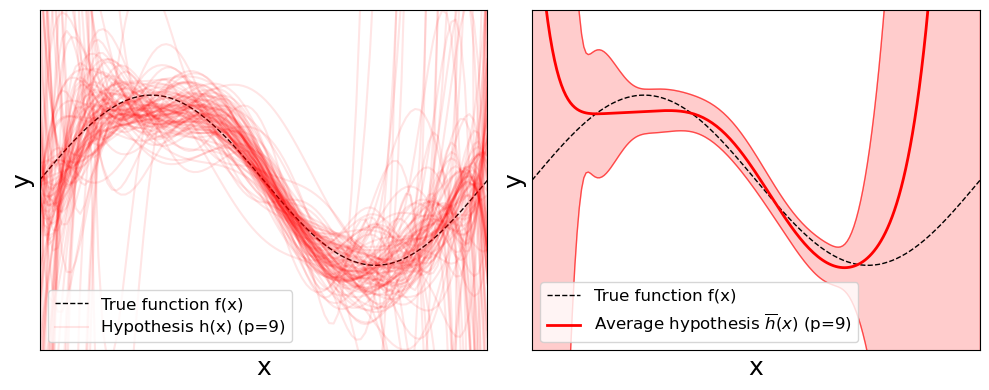

In [7]:
poly_degree = 9

plot_multiple_results(X_train, y_train, poly_degree=poly_degree)

For a more convenient comparison, we again provide you with an animation that cycles through all polynomial degrees $p=0..9$.

<img src="images/animations/biasvariance/biasvariance-effect-of-dataset-sample.gif" />

The results clearly show that with increasing polynomial degree $p$, the individual regression lines described by a hypothesis $h(x)$ will vary more and more; also reflected by the increasing standard deviations. Keep in mind that all models are fitted with the same number of training samples all stemming from the same initial training dataset. The only difference is these subset are randomly sampled each time before fitting a model.

In this situation, where changes on the training set lead to very different solutions, we say the model has a high **variance**. And as mentioned before, the higher the variance, the higher the risk of overfitting &mdash; as the model has a higher risk of learning the noise in the data. A model with a high variance depends heavily on the training data and therefore has a limited ability to generalize to new, unseen inputs. This can result in excellent performance on training data but significantly higher error rates during model verification on the test data. Complex, nonlinear models such as large neural networks often have high variance due to their high flexibility. While the seemingly obvious solution would be to reduce the model's complexity &mdash; here: reducing the polynomial degree &mdash; we already saw that it may result in an increasing model bias. Thus, in practice, other strategies such as **regularization** are used to lower the risk of overfitting; we give a brief overview to different methods at the end.

In contrast to he bias (systematic error), variance introduces a **random error** as the errors change depending on which random sample of data you train on. Variance means a model might make (very) different predictions for unseen data depending on the exact training data &mdash; it is not wrong in the same way, but wrong in unpredictable ways. However, this random nature also means that variance can reduced in two main ways:

* **Larger training data:** The more training samples are available, the less the model will be affected by individual sample noise; over a large number of measurements, random errors tend to cancel each other out. In fact, we have already observed this when we fitted polynomials of degrees $p=0..9$ using the full dataset containing $100$ sampled. We saw that even for $p=9$ our hypothesis $h(x)$ was a good estimate for the true function $f(x)$. Of course, in practice, using more training data is often much easier said than done. For many tasks, generating annotated, high-quality datasets is commonly very costly and resource-intensive.

* **Repeated training and inference:** Similar to the last test, we can train the same model multiple times to get multiple predictions for an unseen sample, and lastly average them to get the final prediction. Of course, this only makes sense if we train the model over actually different datasets. For the test above, we randomly sampled subsets of the original dataset. However, we typically do not want to reduce the dataset size to further increase the variance &mdash; and simply generating more training data is again very difficult. A common strategy to facilitate repeated training is **bootstrapping** (or **bootstrap sampling**), i.e., random sampling with replacement from the available training data. Using multiple models trained on different bootstrap samples for making and averaging predictions is the fundamental idea behind **bagging** (bootstrap aggregation).

### Summary (so far)

Beyond any special cases, no model is perfect, all models make errors. After all, a model, by definition, is a simplified representation of some real-world phenomenon. It's like a mini-version or a blueprint that helps us understand, predict, or create this phenomenon. We rely on models because the real world can be too complex, too big, too expensive, or too dangerous, etc. to work with directly. Although we cannot avoid model errors, we can better understand and thus hopefully minimize them.

In the context of machine learning, we can break down a model's error into two main parts: its **bias** (systematic error; typically associated with **underfitting**) and its **variance** (random error; typically associated with **overfitting**). We saw that both errors are closely linked to the model's complexity and the assumption the model makes. For our example, an overly simple model assuming a linear relationship (i.e., $p=1$) is not able to appropriately capture the true (cubic) relationship between the inputs and outputs. We also saw that we typically have conflicting goals. While increasing a model's complexity tends to increase its bias, it also tends to increase the model's variance. This observation is also called the **bias-variance tradeoff**. While good training data &mdash; where "good" typically refers to representative, high-quality, and sufficiently large datasets &mdash; and the right choice of model family (e.g., Linear Regression, Decision Trees, Neural Networks) help to reduce the overall error, there is no escaping the relationship between bias and variance: increasing the bias will decrease the variance, and vice versa.

An often used way to visualize and explain model bias and variance is the bullseye diagram or a dartboard analogy. This analogy is highly effective because it directly links the spread and center of our "shots" (model predictions) to the concepts of variance and bias; see the figure below. The Target, i.e., the very center of the bullseye represents the true value or the ideal, perfectly accurate prediction. This is what we want our model to hit every time. Each "dart" or "shot" thrown at the target &mdash; each little black circle in the figure below &mdash; represents a single prediction made by our model.

<img src="images/illustrations/biasvariance/biasvariance-targets.png" style="margin:auto" alt="Bias vs Variance: Analogy"/>

The four diagrams reflect the four basic case when discussion high/low bias/variance:

* **Low bias, low variance (top left):** This is the ideal scenario in practice. Almost all darts hit the target almost dead center (low bias) without much spread (low variance). Of course, even the model will not be perfect as the noise in the data (recall error term $\epsilon$) will always affect the prediction to some degree.

* **High bias, low variance (top right):** Here, all darts only have a small spread (low variance), but they hit an area systematically outside the center of the target (high bias). This means our model is not sensitive to changes in the training data, but the predictions are almost always quite wrong, indicating underfitting due to insufficient model complexity.

* **Low bias, high variance (bottom left):** Although all darts now hit spots around the center (low bias), the distribution of hits shows a large spread (high variance). A model showing such a behavior when making predictions is arguably very sensitive to changes in the training data. Most likely the model complexity is too high so the model can learn the noise in the data, which we call overfitting.

* **High bias, high variance (bottom right):** This is arguably the worst case as the model makes large systematic errors (high bias) and large random errors &mdash; indicated by the large spread of hits far off the center. This generally means that the complexity of the model is not appropriately chosen but also that the dataset is of low-quality (i.e., too small, very noisy, or not representative of the true underlying function $f(x)$).

As we have seen before, minimizing both the bias and the variance together is only possible to some extent (e.g., by ensuring high-quality training data). In practice, we often have to make a tradeoff between bias and variance since both errors are directly affected by the complexity of a model, but in an inverse way. While high model complexity generally means a lower bias, it also results in a higher variance, and vice versa.

---

## Definitions & Bias-Variance Decomposition

The goal of the previous section was to give an intuition which fundamental types of errors occur when training a model and how these errors relate to the complexity of capacity of that model. We introduced the notion of bias as a structural error, and variance as a random error, but only illustrated them in a qualitative manner. However, in practice, we also want to compute the bias and the variance of our model to see how well it performs and to tell potentials for improvements.

### Definitions

Let's first properly the define the bias and the variance of a model $h(x)$

#### Bias

The **bias** quantifies how close our hypothesis (i.e., our model) $h(x)$ to the unknown true function $f(x)$, averaged across many dataset sampled based on $y = f(x) + \epsilon$, giving has many hypothesis $h_D(x)$. To this end, we calculate the bias as difference between the expected prediction over different training datasets and the true value given $f(x)$:

$$\large
Bias(h_D(x)) = \mathbb{E}[h_D(x)] - f(x)
$$

where $\mathbb{E}[h_D(x)]$ is the expected prediction over different datasets $D$. Just by looking at the definition we can already see major challenges when it comes to computing the model bias in practice:

* **Unknown function $f(x)$:** Directly computing the bias for our model would require that we know the function $f(x)$. Of course, if we knew $f(x)$, we would not need to train a model in the first place.

* **Multiple datasets:** Computing the expected prediction over different training datasets $D$ requires, well, different datasets $D$ &mdash; and all datasets need to be sampled based on $y = f(x) + \epsilon$. In practice, however, we have a single dataset, and we typically do not want to split this dataset into potentially much smaller subsets.

We have to discuss later, how these issues are addressed in practice.

#### Variance

We saw that changes in the training dataset $D$ may yield very different solutions $h_D(x)$. The model **variance** therefore quantifies the variability of the model &mdash; that is, how much the model is affected by different realizations of the training dataset. Since $h_D(x)$ is a random variable, the definition of the variance of a model is in line with the definition of the variance of a random variable:

$$\large
Variance(h_D(x)) = \mathbb{E}\left[ \left( h_D(x) - \mathbb{E}[h_D(x)] \right)^{2} \right]
$$

As before, $\mathbb{E}[h_D(x)]$ is the expected prediction over different datasets $D$. This means &mdash; while does not rely on the unknown true function $f(x)$ &mdash; we again rely on the availability of different datasets, which poses challenges in practice.

#### Irreducible Error

Recall that our target variable $y$ is assumed to be generated as $y = f(x) + \epsilon$, where $\epsilon$ is a random noise or error term with zero mean and variance $\sigma^2$. This means that each individual sample error $\epsilon_i$ for a data sample pair $(x_i, y_i)$ is sampled from a normal distribution $\epsilon \sim \mathcal{N(0, \sigma^2)}$. This error term represents all the unobserved factors that influence $y$ but are not included in the model. The **irreducible error** is due to this noise term $\epsilon$, which includes:
* Measurement errors
* Unobserved or missing factors
* Intrinsic randomness in the system being modeled

Thus, no matter how much data you collect or how good your model is, it is principally impossible to eliminate this irreducible error. It is called "irreducible" because it is a property of the data itself, not the model. In some sense, the irreducible error sets the lowest possible limit on the accuracy of any predictive model.

### Bias-Variance Decomposition

In general, we assess the quality of a model by how close its predictions $\hat{y}$ to the true values $y$ are. A common measure to quantify is this the **expected squared error** which calculates expected value for the squared difference between the predicted value $\hat{y}$ and the true value $y$, taken over all possible data; more formally:

$$
\begin{align}
\large Error\ &\large = \mathbb{E}\left[(y - \hat{y})^{2}\right]\\[1em]
&\large = \mathbb{E}\left[(y - h_D(x))^{2}\right]
\end{align}
$$

**Important:** Note that the expected squared error is a theoretical average used in theoretical analysis, especially in bias-variance decomposition. For one, the expected squared error is not directly computable since the true function $f(x)$ that computes $y$ is unknown. But also, it represents the average squared error over *all possible data*, which is of course not available in practice. Again, we discuss practical consideration regarding model evaluation in a later section.

The equation for the model error as given above, however, does not tell us how our three types of errors &mdash; bias, variance, and irreducible error &mdash; contribute to the overall error. It can be shown that for regression tasks modeled as $y = f(x) + \epsilon$ and assuming the expected squared error, the overall model error can be decomposed as:

$$\large
Error = Bias^2 + Variance + Irreducible\ Error
$$

In a separate notebook, we go through the bias-variance decomposition step by step to exactly see where the equation above is coming from. However, we can visualize the decomposition and the general relationship between the bias and the variance; see the figure below.

<img src="images/illustrations/biasvariance/biasvariance-total-error.png" style="margin:auto" alt="BiasVariance Decomposition"/>

In simple terms, this decomposition allows us to express the total model error as a combination of bias error, variance error, and irreducible error. This, in turn, to better assess as well as improve a model's performance; more specifically:

* **Insight into the bias-variance tradeoff:** The decomposition highlights that there is typically an inverse relationship between bias and variance. Simple models (e.g., Linear Regression on complex non-linear data) tend to have high bias (underfitting) and low variance (they are not very sensitive to changes in training data). In contrast, complex models (e.g., deep neural networks with many parameters) tend to have low bias (can fit complex patterns) but high variance (overfitting to training data, highly sensitive to data fluctuations). The goal is to find a model complexity that achieves a good balance between bias and variance, minimizing the total generalization error.

* **Understanding underfitting and overfitting**: The decomposition provides a clear framework for diagnosing whether a model is underfitting (high bias) or overfitting (high variance). This understanding is critical for choosing appropriate model adjustments.

* **Role of data quantity:** The bias-variance decomposition and the definitions of variance suggests that as the amount of training data increases, the variance of learned models tends to decrease. Therefore, with more data, methods that learn models with lesser bias might be preferred.

* **Foundation for regularization techniques:** Many regularization methods (e.g., Lasso, Ridge regression) are conceptually rooted in the bias-variance trade-off. These methods intentionally introduce a small amount of bias into the model to significantly reduce variance, leading to better overall performance (lower Mean Squared Error).

* **Justifies cross-validation and ensemble methods:** Bias-variance decomposition explains why cross-validation is crucial to estimate generalization error reliably. It also justifies the effectiveness of ensemble techniques (e.g., random forests), which reduce variance without increasing bias much.

### Decomposition for Classification Task

The bias-variance decomposition shown in this notebook is based on the expected squared error commonly used in regression tasks. Of course The bias-variance tradeoff also applies to **classification tasks**, including those that use **cross-entropy loss** for example, although its interpretation differs slightly from regression with squared error. In classification, especially probabilistic models, cross-entropy loss measures the difference between the predicted probability distribution and the true distribution (typically a one-hot vector indicating the correct class). Like in regression, model errors can be decomposed into **bias**, **variance**, and **irreducible error**, though the decomposition is more nuanced and less mathematically clean due to the nature of classification outputs.

* **Bias** in classification (with cross-entropy) refers to how far the model's *average predicted probabilities* are from the true class distribution. A high-bias model might predict probabilities that are consistently too close to uniform or strongly favor incorrect classes, often due to underfitting or overly strong assumptions (like linearity or insufficient depth in a neural net).

* **Variance** refers to how much the model’s predictions fluctuate for different training datasets. A high-variance classifier might give very different probability distributions for the same input depending on the specific training set it saw, indicating overfitting to noise in the data.

* The **bias-variance tradeoff** describes the tension between these two: as you increase model complexity to reduce bias (e.g., deeper networks or more flexible decision boundaries), variance often increases. Conversely, simplifying a model to reduce variance can increase bias. The goal is to find a model that generalizes well to new data — not too simple (high bias), not too unstable (high variance).

Even though the exact mathematical decomposition of cross-entropy error into bias and variance is complex and not as neat as for squared error loss, the **core intuition still holds**: Choosing the right model complexity is key to balancing systematic errors and sensitivity to data fluctuations, ultimately minimizing the expected cross-entropy loss on unseen data.

---

## Discussion & Practical Considerations

As mentioned before, the true model bias and variance cannot be directly calculated as the true function $f(x)$ is unknown and involves expectations over the entire data-generating distribution, which are also never fully known. This means that in practice, we can only ever estimate the bias and variance of a model, or at least get some insights if the bias or the variance might be dominating the overall model error. Let's briefly go over some common methods used in practice &mdash; each method will be covered as its own topic.

### Bootstrap Sampling

The general idea of repeated sampling is to (artificially) generate multiple dataset based on the initially given dataset. One of the most common approaches is **bootstrap sampling.** Bootstrap sampling is a statistical technique used to estimate properties of a population by repeatedly sampling from a dataset with replacement. In each iteration, a new sample (called a bootstrap sample) is created by randomly selecting data points from the original dataset, allowing the same data point to appear multiple times. Each bootstrap sample &mdash; reflecting a current dataset $D$ in our discussion above &mdash; is typically the same size as the original dataset.

Each bootstrap sample $D$ is then used to train a separate model, which is then evaluated by comparing its predictions with the true values given a fixed test sample or test dataset. The ensemble of predictions then allows us to estimate the bias and variance of the model. While bootstrap sampling is a very useful technique to estimate a model's bias and variance, it also has various limitations that need to be considered; more specifically:

* **Computation costs:** Estimating bias and variance with bootstrap sampling requires training a model on many resampled datasets (often hundreds or thousands), with each bootstrap sample often very large (typically the same size as the initial dataset). This can be computationally expensive, especially for large models like deep neural networks, and may be impractical without significant computing resources.

* **Dependence on the original dataset:** The fundamental assumption of bootstrap sampling is that the original dataset is both sufficiently large and representative of the true data distribution. If the initial dataset is biased or not diverse enough, the bootstrap samples will simply perpetuate that bias. *Bootstrap sampling does not create new information*; it just reuses the information already present in your sample. In simple terms, you cannot "bootstrap your way out" of a poor initial dataset. If the initial dataset is too small many bootstrap samples will be very similar, and the resulting estimates of variance might be underestimated, and bias estimates might be unreliable.

* **Limited accuracy for bias estimation:** Bootstrap methods can estimate variance fairly well, but they are less reliable for estimating bias, especially if the model is highly nonlinear or the data contains noise. Since bias estimation requires knowing the "true" target values, and we only observe noisy outcomes, the estimated bias can be misleading or biased itself.

* **Overfitting to reused data points:** Each bootstrap sample includes many repeated data points, and some original points may be left out entirely (on average, about 37% are not included in each sample). This can lead to overfitting or unstable models, especially if the model is sensitive to data variations, which in turn affects the accuracy of bias and variance estimates.

### k-Fold Cross-Validation

Another sampling method is to assess how well a machine learning model generalizes to unseen data is k-fold cross-validation. It works by dividing the dataset into $k$ equal-sized folds (subsets). The model is trained $k$ times, each time using a different fold as the validation set and the remaining $k−1$ folds as the training set. The performance in terms of the prediction errors is then averaged across the $k$ runs to get a more robust estimate of the model's generalization error. k-fold cross-validation provides indirect insights into a model’s bias and variance by comparing performance across training and validation folds:

* **High Bias (Underfitting):** If both the training and validation errors are both high and consistent across all folds, the model is most likely too simple to capture underlying (more complex) patterns in the data. This indicates that our model is underfitting due to a high bias.

* **High Variance (Overfitting):** If training error is low, but validation error is high and varies significantly between folds, the model is most likely to be too complex and sensitive to changes in the data. In other words, the model has too much capacity and learns the noise in data. This indicates overfitting due to a high variance.

By analyzing the average errors and their variability across folds, one can assess whether a model tends to underfit or overfit, and choose appropriate strategies (e.g., adjusting model complexity, using regularization, or collecting more data) to address the issue. This makes k-fold cross-validation an essential tool for diagnosing and improving model performance in practice.

Compared to bootstrap sampling, k-fold cross-validation is less computationally extensive since only $k$ models are trained (compared to hundreds or thousands in case of bootstrap sampling). However, k-fold cross-validation does not allow you to directly estimate the model's bias and variance. It "only" provides indirect and practical insights into bias and variance through observed error patterns across folds; see above. So while we cannot compute estimates for the bias and the variance, we can still get reliable estimates of the model's overall generalization performance for model selection and hyperparameter tuning.

### Learning Curves

Recall that we used (Polynomial) Linear Regression to give you an intuition for the model bias and variance. Even for higher-order polynomials, the model is still simple enough so that the best values for all the weights (or parameters) $w_i$ can directly be found analytically. For more complex models, particularly neural networks, finding the best parameter values analytically is no longer possible. Training neural network generally means starting with a random choice for all parameters and using methods such as Gradient Descent or its variants to **iteratively** update the parameter values such that the model fits the training data better and better. The training typically involves multiple **epochs**, where an epoch refers to one complete pass through the entire training dataset by the learning algorithm (e.g., Gradient Descent). 

To get important insights regarding the bias and variance of the model we are training, we can compute the error (or loss) for both the training and the validation data after each epoch. This allows us to plot the trends of the training error and the validation error over time (i.e., over all epochs), which can be interpreted as the models learning curves; naturally, the lower the better. The figure below shows an example for such learning curves.

<img src="images/illustrations/biasvariance/biasvariance-learning-curves.png" style="margin:auto" alt="Example: Learning Curves"/>

At the beginning of the training, the model will typically perform poorly on both the training and validation data because the learnable parameters are likely to be still far away from the optimal values. Similar to k-fold cross-validation, we have the situation where both the training and validation error is high, indicating underfitting due to a high bias. In contrast, if we train the model for too many epochs, the model is more likely to learn the noise in the training data and is less likely to generalize well on unseen data. Again, we observe a low training error but a high validation error, indicating overfitting due to high variance. The sweet spot is generally where the validation error is smallest, and therefore our model generalizes best on unseen data. Thus, **early stopping** is a very common method to end the training once the validation error stops to decrease (and may even start to increase again).

Two small comments regarding this figure showing an example of learning curves:

* In practice, the curves are unlikely to be as smooth as shown in the figure above. Can curves may show more erratic trends when training on real-world data, often making it very difficult to pinpoint the sweet spot. Also, if the modeled phenomenon is not very complex and the training dataset is large and representative, the training and validation error might no even start to diverge since no overfitting is happening (unfortunately, not very common in practice).

* Instead of the loss or error, the learning curves may also show the prediction quality of the model in terms of accuracy, F1 score, etc. In this case, the higher the value the better, and the learning curves are "flipped" compared to the one shown in the previous figure. However, the interpretation is analogous: At the start, say, both the training and validation accuracies are still low (indicating underfitting) and increase over time. At some point (i.e., epoch), the validation accuracy stops increasing and diverges from the training accuracy (indicating overfitting).

Like k-fold cross-validation, learning curves do not allow us to actually estimate the bias and variance (in terms of actual values), but give us useful indicators if our model is more likely to suffer from a high bias or a high variance. In some sense, the learning curves also come for "free" since we have to compute the train error or loss for the training anyway. Only computing the validation loss after each epoch is an additional step as it is not required for the training.

---

## Summary

In machine learning, **model bias** and **model variance** are two fundamental sources of error that affect a model's performance. **Bias** refers to the error introduced by approximating a real-world problem, which may be complex, with a simplified model. High bias typically results in **underfitting**, where the model is too simplistic to capture underlying patterns in the data. **Variance**, on the other hand, refers to the model’s sensitivity to small fluctuations in the training data. High variance results in **overfitting**, where the model captures noise instead of the underlying pattern, performing poorly on new, unseen data.

Understanding the concepts of bias and variance is crucial because they explain the **tradeoff between model complexity and generalization**. A model that is too simple (like a linear model for a non-linear relationship) will have high bias and consistently poor performance across datasets. Conversely, a model that is too complex (like a high-degree polynomial) may perfectly fit the training data but fail to generalize, resulting in high variance. The goal in practice is to find the **right balance**, minimizing both bias and variance to achieve good performance on both training and test data.

Learning about model bias and variance helps you make informed decisions when training models. For instance, if a model is performing poorly on both training and test data, the issue may be high bias, suggesting that a more complex model or better features are needed. If the model performs well on training data but poorly on test data, the issue may be high variance, and techniques such as regularization, cross-validation, or ensemble methods can be used to improve generalization.

Moreover, the bias-variance framework is important for **debugging model performance** and understanding **why a model fails**. It provides a structured way to diagnose issues and iterate effectively on model design, rather than relying on trial and error. This understanding is especially critical in real-world applications, where the cost of model errors can be high.

In summary, mastering the concepts of bias and variance is essential for building robust and reliable machine learning models. It empowers you to tune models more effectively, interpret errors meaningfully, and ultimately, create systems that perform well not only in theory but in practical, real-world scenarios.